In [280]:
## Recoded for public release 4/26/2024

In [69]:
## Input files
#  ALL.chr9.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz
#  ALL.chr9.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz.tbi (not really needed)

## Derived input file (contains VCF row and corresponding allele frequency)
#  All.chr9.v5b.linenum.AF.txt

## Example of bash command lines needed to create derived input file:
#  gatk VariantsToTable -V ALL.chr9.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz -F AF -O All.chr9.v5b.linenum.AF.1.txt
#  cat All.chr9.v5b.linenum.AF.1.txt | grep -v "AF" > All.chr9.v5b.linenum.AF.2.txt
#  cat -n All.chr9.v5b.linenum.AF.2.txt > All.chr9.v5b.linenum.AF.txt
#  rm All.chr9.v5b.linenum.AF.1.txt
#  rm All.chr9.v5b.linenum.AF.2.txt

## Optional input file: Putative PRDM9 binding sites (recombination hotspots)
#  ChIPseq_Peaks.YFP_HumanPRDM9.antiGFP.protocolN.p10e-5.sep250.Annotated.txt

## Output file (score file)
#  chr9.corboxscores.corcut.p45.4000.500.txt

In [70]:
## install.packages('corpcor')
## install.packages('fdrtool')

In [71]:
## Get needed libraries
library(corpcor)
library(fdrtool)

In [72]:
## Parameters

## Output file names
scorefile <- 'chr9.corboxscores.corcut.p45.4000.500.txt'

## Analysis Description
adesc <- "This scoring uses 1000G, and this is a regular run"

n <- 4000     # Set the analysis block size (this is somewhat arbitrary, but needs to be larger then 2 times bx_sz (prefer 4x to 10x)
bx_sz <- 500  # set the dimension of the area/box to be summed

## Choose filtering method. usefdr = TRUE uses FDR, otherwise use correlation
usefdr <- FALSE

## Choose to use shrinkage or not
useshrink <- FALSE

## Use weigthed values instead of threshold cutoffs
useweighted <- FALSE

## Set cut point. Anything below 5E-6 to 1E-14 seem to yield similar for fdr
## Correlation is less obvious, probably between 0.3 and 0.6 for 1000G
cutoff <- 1E-10
corcutoff <- .45

## Pad value (value used to represent the uncomputable ends of the chromosome)
padval <- -1

## Set MAF cutoff (0.05 is greater than or equal to .05,
## and is also less than or equal to .95). This is needed to deal with AF > .5 in VCF
maf_cutoff <- 0.05

In [73]:
## Read the allele frequency file (chromosome 9 in this case)
## Note that this file contains two columns, the VCF file pointer (offset from first VCF record in file),
## and the allele frequency.
afpath <- ''
infile <- 'All.chr9.v5b.linenum.AF.txt'
affile <- paste(afpath, infile, sep = '')
af_fidx <- read.table(affile, header = FALSE, stringsAsFactors = FALSE)
colnames(af_fidx) <- c('fidx', 'af')

In [74]:
## Get indexes to the common alleles
com_af_vidx <- which((af_fidx[,2] >= maf_cutoff) & (af_fidx[,2] <= (1 - maf_cutoff)))

In [75]:
## Open the variant file
vcfpath <- ''
vcffile <- 'ALL.chr9.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz'
vcfcon <- file(paste(vcfpath, vcffile, sep =''), open = 'r' )

In [76]:
## Create the output file, initialize it with the first block of data
## Open the corr score filt'
scorepath <- ''
scorefp <- paste(scorepath, scorefile, sep ='')

In [77]:
## Write the parameters used for this analysis in comment lines of the score file
write(file = scorefp, paste("## ", adesc, sep = ''))
write(file = scorefp, paste("## LD Alternative, Run on ", Sys.Date(), sep = ''), append = TRUE)
write(file = scorefp, paste("## Input VCF file: ", vcffile, sep = ''), append = TRUE)
write(file = scorefp, paste("## Input Allele Frequency file: ", infile, sep = ''), append = TRUE)
write(file = scorefp, paste("## Allele Frequency Cutoff: ", maf_cutoff, sep = ''), append = TRUE)
write(file = scorefp, paste("## Total No. of Common Variants: ", length(com_af_vidx), sep = ''), append = TRUE)
write(file = scorefp, paste("## Analysis Window Size: ", n, sep = ''), append = TRUE)
write(file = scorefp, paste("## Analysis Box/Area Size (per side): ", bx_sz, sep = ''), append = TRUE)
if (usefdr) cutoff_method <- "FDR Threshold" else cutoff_method = "Correlation Threshold"
write(file = scorefp, paste("## Cutoff Method: ", cutoff_method, sep = ''), append = TRUE)
if (usefdr) cutoff_thresh <- cutoff else cutoff_thresh = corcutoff
write(file = scorefp, paste("## Cutoff Threshold: ", cutoff_thresh, sep = ''), append = TRUE)
write(file = scorefp, paste("## Use Weighted Sums Instead: ", useweighted, sep = ''), append = TRUE)
write(file = scorefp, paste("## Shrinkage Used: ", useshrink, sep = ''), append = TRUE)
write(file = scorefp, paste("## Output Score file: ", scorefile, sep = ''), append = TRUE)
write(file = scorefp, paste("## Begin/End Chromosome Pad Values: ", padval, sep = ''), append = TRUE)
coltitles <- c('filepos_up, filepos_down, chrpos_up, chrpos_down, box_score')
write(file = scorefp, paste("## Column Names", sep = ''), append = TRUE)
write(file = scorefp, paste("## ", coltitles, sep = ''), append = TRUE)

In [78]:
## Function used to convert VCF text genotypes into integer coded haploid (ref = 0, alt = 1)
## This function doubles the number participants
ext_haploid <- function(vars_x) {
    ## Extract the two alleles (0 or 1) into seperate integer vectors
    vars_left_i <- as.integer(unlist(lapply(vars_x, substr, 1,1)))
    vars_right_i <- as.integer(unlist(lapply(vars_x, substr, 3,3)))
    ## Convert the vectors to matrices and aggregate the pairs of alleles
    vars_left_im <- matrix(vars_left_i, nrow = dim(vars_x)[1], ncol = dim(vars_x)[2])
    vars_right_im <- matrix(vars_right_i, nrow = dim(vars_x)[1], ncol = dim(vars_x)[2])
    ## Concatenate and transpose the results
    vars_im <- t(cbind(vars_left_im, vars_right_im))   # Concatenation
    return(vars_im)            
}

In [79]:
## Read the HumanPRDM9 binding information (putative hotspots)
hotpath <- ''
hotfile <- 'ChIPseq_Peaks.YFP_HumanPRDM9.antiGFP.protocolN.p10e-5.sep250.Annotated.txt'
hotfp <- paste(hotpath, hotfile, sep = '')
hotspots <- read.table(hotfp, header = TRUE)[,1:10]

## Notice that this hardcoded for chr9. Change as needed.
## Get just the positions of hotspots in chr9
chr9hot <- hotspots[hotspots$chr == 'chr9', 'center_start']

In [80]:
## Read up to through first n common variants to get things set up
lastrec <- af_fidx[1,1] - 1
ncom <- com_af_vidx[n]
totlines <- lastrec + ncom
vcfcon <- file(paste(vcfpath, vcffile, sep =''), open = 'r' ) ## Reset file pointer
firstnall <- readLines(vcfcon, n = 1000) ## Get the comment lines (readying first 1000 lines should be enough)
## Need to remove comment lines. First get number of comment lines
ncomments <- sum(substr(firstnall, 1, 1) == "#")
vcfcon <- file(paste(vcfpath, vcffile, sep =''), open = 'r' ) ## Reset file pointer
firstnall <- readLines(vcfcon, n = ncomments) # Read/Flush the comment lines
firstnall <- readLines(vcfcon, n = totlines) # Read the first block of variants

In [81]:
## Set up the containers for the variant records (paramaters and participant variants)
npars <- 9 # This is the vcf definition
nparts <- length(unlist(unlist(strsplit(firstnall[com_af_vidx[1] + lastrec], '\t')))) - npars
pars <- matrix('', nrow = n, ncol = npars)
vars <- matrix('', nrow = n, ncol = nparts)

In [82]:
## Initialize pars and vars with first round of n common variant records
## This does most of the magic of extracting just the common allele informations
for (i in 1:n) {
    psandvs <- unlist(unlist(strsplit(firstnall[com_af_vidx[i] + lastrec], '\t')))
    pars[i,] <- psandvs[1:npars]
    vars[i,] <- psandvs[(npars + 1):(nparts + npars)]
}

In [83]:
## Convert the diploid character based variants into haploid integer based variants 
vars_im <- ext_haploid(vars)

In [84]:
## Get the first correlation matrix
if (useshrink) pc_vars <- cor.shrink(vars_im) else pc_vars <- cor(vars_im)

In [85]:
## Vectorize the matrix (below the diagonal)
pc_vars_v <- sm2vec(pc_vars)
pc_vars_in <- sm.index(pc_vars)

In [86]:
## Compute the false discovery rates, if needed
if (usefdr) pc_vars_fdr <- fdrtool(pc_vars_v, statistic = 'correlation')

In [87]:
## filter at cut point according to parms set above
if (usefdr) cutvec <- pc_vars_fdr$qval <= cutoff else cutvec <- (abs(pc_vars_v) >= corcutoff)

## Force all the positive values to 1 if not weighted, otherwise use absolute correlation value
if (!useweighted) {
    pc_vars_vfilt <- rep(0, length(pc_vars_v))
    pc_vars_vfilt[cutvec] <- 1 }
if(useweighted) pc_vars_vfilt <- abs(pc_vars_v) 

## Convert the vector back into a symmetric matrix, force the diagonal to 1
pc_vars_filt01 <- vec2sm(pc_vars_vfilt)
diag(pc_vars_filt01) <- 1

In [88]:
## Get the matching positions of the filtered variants
vars_im_pos <- pars[,2]

In [89]:
pc_vars_filt_start <- pc_vars_filt01

In [90]:
# get lower positions of nearest hotspot for each variant in this window
hotspot_var <- vector(mode = 'integer', length = length(vars_im_pos))
for (i in 1:length(vars_im_pos)){
   hotspot_var[i] <- which(vars_im_pos[i] <= chr9hot)[1]
}

In [91]:
# Get just line positions of hotspots in chr9
chr9hot <- hotspots[hotspots$chr == 'chr9', 'center_start']
hotgridpoints <- which(hotspot_var[1:(length(hotspot_var)-1)] != hotspot_var[2:length(hotspot_var)])

In [92]:
## Compute the box sums for first block
bx_sms <- rep.int(padval, times = n - 1)
# names(bx_sms) = paste('B', as.character(1:(rg_sz-1)),'_',
#                       as.character(2:rg_sz), sep ='') 
names(bx_sms) = paste('B', as.character(1:(n - 1)), '_',
                      as.character(2:n), sep = '') 
for (i in (1:(n - 2 * bx_sz + 1))) {
    bx_sms[i + bx_sz - 1] = sum(pc_vars_filt01[i:(i + bx_sz - 1),
                                               (i + bx_sz):(i + 2 * bx_sz - 1)])
    }

In [95]:
## Create the first section to write (it includes the left most data, which was forced to padval)
score_mat <- cbind(com_af_vidx[1:(n-bx_sz)],
                   com_af_vidx[2:(n-bx_sz + 1)],
                   vars_im_pos[1:(n-bx_sz)],
                   vars_im_pos[2:(n-bx_sz + 1)],
                   bx_sms[1:(n - bx_sz)])
# colnames(score_mat) <- c('filepos_up', 'filepos_down', 'chrpos_up', 'chrpos_down', 'box_score')

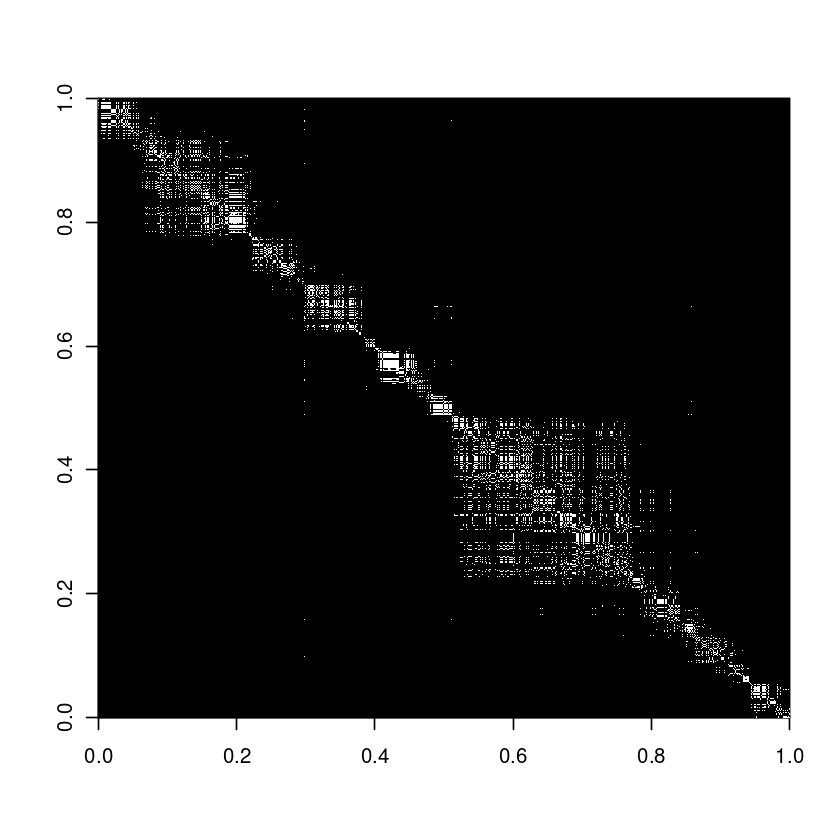

In [96]:
## Plot the first block correlation matrix (for information only)
image(pc_vars_filt_start[1:n, n:1], col = c('black', 'white'))

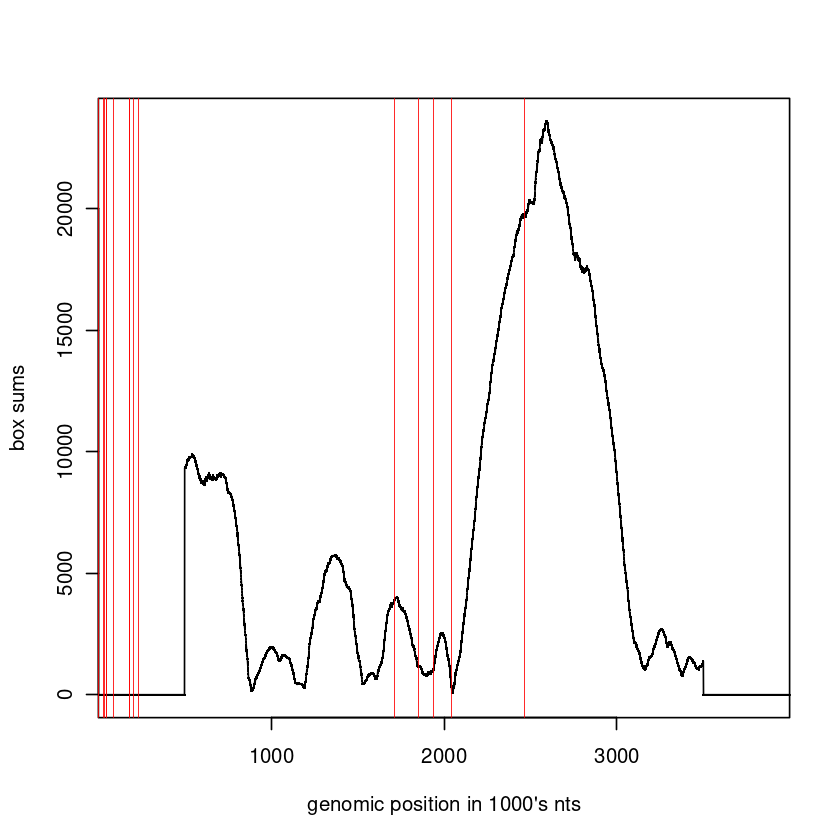

In [97]:
## Plot the first block box scores (for information only)
plot(bx_sms, type = 'o', pch = 46, x = (1:(n - 1)),
    xlab = "genomic position in 1000's nts",
    ylab = 'box sums', xaxs = "i")
## Overlay the PRDM9 hotspot gridpoints (putative binding sites
abline(v = hotgridpoints, col = 'red', lwd = .5)

In [98]:
## Write out the first block, append
write.table(score_mat, file = scorefp, quote = FALSE,
            sep = '\t', append = TRUE, row.names = FALSE, col.names = FALSE)

In [99]:
## Compute the number of iterations needed to scan
## the chromosome (exclude very top region + 1 group)
no_its <- as.integer((length(com_af_vidx) / (n - 2 * bx_sz + 1)))

In [100]:
## Initialize iterative genotype variable with the first read  
vars_im2 <- vars_im
## Initialize parameters matrix with first set of parameters
pars2 <- pars
## Initialize loop parameters
cvend <- n
cvinc <- n - 2 * bx_sz + 1

In [ ]:
## Loop through the remaining blocks less the very end block

for (i in 1:(no_its - 2)) { # All but the last two iterations, as it will be a regular and short set
    
    cvstart <- cvend
    cvend <- cvstart + cvinc
    com_af_vidx[cvstart]
    com_af_vidx[cvend]
    ncomi <- com_af_vidx[cvend] - com_af_vidx[cvstart] 
    
    nextn_minus_2bx <- readLines(vcfcon, n = ncomi)
    # print(substr(nextn_minus_2bx[length(nextn_minus_2bx)], 1, 100))

    ## Find the pointers to the new common variants in this iteration
    cv <- com_af_vidx[(cvstart + 1):cvend] - com_af_vidx[cvstart] 
    
    ## Set up the containers for the variant records (paramaters and participant variants)
    loop_pars <- matrix('', nrow = cvinc, ncol = npars)
    loop_vars <- matrix('', nrow = cvinc, ncol = nparts)

    for (j in 1:cvinc) {
        psandvs <- unlist(unlist(strsplit(nextn_minus_2bx[cv[j]], '\t')))
        loop_pars[j,] <- psandvs[1:npars]
        loop_vars[j,] <- psandvs[(npars + 1):(nparts + npars)]
        } 
    ## Convert the diploid character variants into haploid integer variants 
    loop_vars_im <- ext_haploid(loop_vars)
    ## Shift the genotypes and append the newly read genotypes
    vars_im2 <- cbind(vars_im2[,(cvinc + 1):(n)] , loop_vars_im) 
    
    ## Shift the parameters object and append the newly read parameters
    pars2 <- rbind(pars2[(cvinc + 1):(n),] , loop_pars)
    # print(dim(vars_im))
    
    ## Get the iterated correlation matrix
    if (useshrink) pc_vars2 <- cor.shrink(vars_im2, verbose = FALSE) else pc_vars2 <- cor(vars_im2)
    
    ## Vectorize the matrix (below the diagonal)
    pc_vars_v2 <- sm2vec(pc_vars2)
    
    ## Compute the false discovery rates
    if (usefdr) pc_vars_fdr2 <- fdrtool(pc_vars_v2, statistic = 'correlation', plot = FALSE, verbose = FALSE)
    
    ## filter in at cut point
    if (usefdr) cutvec2 <- pc_vars_fdr2$qval <= cutoff else cutvec2 <- abs(pc_vars_v2) >= corcutoff

    ## Force all the positvie values to 1 if not weighted, otherwise use absolute correlation value
    if (!useweighted) {
        pc_vars_vfilt <- rep(0, length(pc_vars_v2))
        pc_vars_vfilt[cutvec2] <- 1 }
    if(useweighted) pc_vars_vfilt <- abs(pc_vars_v2) 
    
    
    ## Convert the vector back into a symmetric matrix, force the diagonal to 1
    pc_vars_filt01 <- vec2sm(pc_vars_vfilt)
    diag(pc_vars_filt01) <- 1
    
    ## Get the matching positions of the filtered variants
    vars_im_pos2 <- pars2[,2]
    
    ## Compute the box sums
    bx_sms2 <- rep.int(padval, times = n - 1)
    for (j in (1:(n - 2 * bx_sz + 1))) {
        bx_sms2[j + bx_sz - 1] <- sum(pc_vars_filt01[j:(j + bx_sz - 1),
                                                   (j + bx_sz):(j + 2 * bx_sz - 1)])
        }
    
    ## Create the iterated section to write (it will exclude the left and right most data
    score_mat2 <- cbind(    com_af_vidx[(cvstart - bx_sz + 1):(cvend - bx_sz + 0)],
                            com_af_vidx[(cvstart - bx_sz + 2):(cvend - bx_sz + 1)],
                            vars_im_pos2[(bx_sz + 0):(n - bx_sz + 0)],
                            vars_im_pos2[(bx_sz + 1):(n - bx_sz + 1)],
                            bx_sms2[(bx_sz):(n - bx_sz)])
     
    ## Write out the appropriate subset of the iterated block, appended   
    write.table(score_mat2, file = scorefp, quote = FALSE,
                sep = '\t', append = TRUE, row.names = FALSE, col.names = FALSE)    
}

In [ ]:
## This is the beginning cell that manages the stub/remainder  
remain <- length(com_af_vidx) - cvend
newn <- n - cvinc + remain 
cvinc_r <- length(com_af_vidx) - cvend
cvstart_r <- cvend
cvend_r <- cvstart_r + cvinc_r
ncomi_r <- com_af_vidx[cvend_r] - com_af_vidx[cvstart_r]

In [ ]:
## Read the remaining common variant records
nextn_minus_2bx <- readLines(vcfcon, n = ncomi_r)
# print(substr(nextn_minus_2bx[length(nextn_minus_2bx)], 1, 100))

## Find the pointers to the new common variants in this iteration
cv <- com_af_vidx[(cvstart_r + 1):cvend_r] - com_af_vidx[cvstart_r] 
    
## Set up the containers for the variant records (paramaters and participant variants)
loop_pars <- matrix('', nrow = cvinc_r, ncol = npars)
loop_vars <- matrix('', nrow = cvinc_r, ncol = nparts)

In [ ]:
for (j in 1:cvinc_r) {
    psandvs <- unlist(unlist(strsplit(nextn_minus_2bx[cv[j]], '\t')))
    loop_pars[j,] <- psandvs[1:npars]
    loop_vars[j,] <- psandvs[(npars + 1):(nparts + npars)]
    } 
## Convert the diploid text variants into haploid integer variants 
loop_vars_im <- ext_haploid(loop_vars)
## Shift the genotypes and append the newly read genotypes
vars_im2 <- cbind(vars_im2[,(cvinc + 1):(n)] , loop_vars_im) # Use the old increment for shifting

In [ ]:
## Shift the parameters object and append the newly read parameters
pars2 <- rbind(pars2[(cvinc + 1):(n),] , loop_pars)
# print(dim(vars_im))
    
## Get the iterated correlation matrix
if (useshrink) pc_vars2 <- cor.shrink(vars_im2, verbose = FALSE) else pc_vars2 <- cor(vars_im2)

## Vectorize the matrix (below the diagonal)
pc_vars_v2 <- sm2vec(pc_vars2)
    
## Compute the false discovery rates
if (usefdr) pc_vars_fdr2 <- fdrtool(pc_vars_v2, statistic = 'correlation', plot = FALSE, verbose = FALSE)

In [ ]:
## filter in at cut point
if (usefdr) cutvec2 <- pc_vars_fdr2$qval <= cutoff else cutvec2 <- abs(pc_vars_v2) >= corcutoff

## Force all the positvie values to 1
# pc_vars_vfilt <- rep(0, length(pc_vars_v2))
# pc_vars_vfilt[cutvec2] <- 1

## Force all the positvie values to 1 if not weighted, otherwise use absolute correlation value
if (!useweighted) {
    pc_vars_vfilt <- rep(0, length(pc_vars_v2))
    pc_vars_vfilt[cutvec2] <- 1 }
if(useweighted) pc_vars_vfilt <- abs(pc_vars_v2) 

## Convert the vector back into a symmetric matrix, force the diagonal to 1
pc_vars_filt01 <- vec2sm(pc_vars_vfilt)
diag(pc_vars_filt01) <- 1
    
## Get the matching positions of the filtered variants
vars_im_pos2 <- pars2[,2]

In [ ]:
## Compute the box sums
bx_sms2 <- rep.int(padval, times = newn - 1)
for (j in (1:(newn - 2 * bx_sz + 1))) {
    bx_sms2[j + bx_sz - 1] = sum(pc_vars_filt01[j:(j + bx_sz - 1),
    (j + bx_sz):(j + 2 * bx_sz - 1)])
    }

In [ ]:
## Create the iterated section to write (it will exclude the left and right most data
score_mat2_r <- cbind(com_af_vidx[(cvstart_r - bx_sz + 1):(cvend_r-1)],
                    com_af_vidx[(cvstart_r - bx_sz + 2):(cvend_r + 1-1)],
                    vars_im_pos2[(bx_sz + 0):(newn + 0-1)],
                    vars_im_pos2[(bx_sz + 1):(newn + 1-1)],
                    bx_sms2[(bx_sz):(newn-1)])

In [ ]:
## Write out the appropriate subset of the iterated block, appended   
write.table(score_mat2_r, file = scorefp, quote = FALSE,
            sep = '\t', append = TRUE, row.names = FALSE, col.names = FALSE)